In [1]:
### summary: TOP SCORES: 
#52.5% with gaussian naive bayes
#52.5% with k-nn with ~200 neighbors
#52.5% with logistic regression and C~1e-2
#52% with a 2 depth decision tree
#always going for 1 -> 51%

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn import linear_model
matplotlib.style.use('ggplot')
%matplotlib inline


In [2]:
numerai_data = pd.read_csv("../numerai_datasets/numerai_training_data.csv")
print numerai_data.head(10)

#separating train and test
frac_for_training = 0.80
training_data = numerai_data.sample(frac=frac_for_training)
validation_data = numerai_data.drop(training_data.index)
check = pd.merge(training_data, validation_data, how='inner')

training_data.drop('validation', axis=1, inplace=True)
validation_data.drop('validation', axis=1, inplace=True)

print('\n\n\nSize of datasets: total - %s, train - %s, test - %s, intersect: %s' %(
        numerai_data.shape[0], training_data.shape[0], validation_data.shape[0], check.shape[0]))

          f1         f2         f3         f4         f5         f6  \
0  134182390   97300587  135824563   90767607   87687197   65148427   
1   76630357  132348601   78121737  102794263  120848626  128752983   
2  111610401  132186734   83887688  120772423  133722193  100560251   
3   72896251  113365043   72912608  126007508  127949612   74975809   
4  113253706   96665624   89391907   77862818   91855586  100094204   
5  122837395   71633727  125829672   73401946   66388998   71572170   
6  116917069   97255589  109352915   77622874   76834712   84847106   
7  108136714  110264481   99080283   95949194  108265520  100203479   
8  116917069  127552518  124961581  102269449  107669715   84416921   
9  107480622   91552319   78127446   84411308   98566229   84213901   

          f7         f8         f9        f10        f11        f12  \
0  109834029  131613166  135533479   92106582   98111205   87052852   
1   71827456   95945691   98115812  135285479  137364637  130062214   
2   6

In [56]:
#naive bayes gaussian

from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score

nb_gaussian_training_data = training_data.copy(deep = True)

try:
    nb_gaussian_training_data["c1_int"] = nb_gaussian_training_data["c1"].apply(lambda x: int(x[3:]))
except Exception:
    le = preprocessing.LabelEncoder()
    le.fit_transform(list(set(nb_gaussian_training_data["c1"])))
    nb_gaussian_training_data["c1_int"] = le.transform(np.asarray(nb_gaussian_training_data["c1"]))

#features:
features = list(set(nb_gaussian_training_data.columns).difference({'target', 'validation','c1'}))
print ("\n\n\nFeatures are: %s" %','.join(features))

#minmax_scale = preprocessing.MinMaxScaler().fit(nb_gaussian_training_data[features])
#nb_gaussian_training_data[features] = minmax_scale.transform(nb_gaussian_training_data[features])


#print nb_gaussian_training_data[features].head(20)

class modified_GaussianNB(GaussianNB):
    def predict(self, X):
        preds = self.predict_proba(X)
        target_one_index = self.classes_.tolist().index(1)
        return preds[:,1].tolist()

#Cross validation score
clf = GaussianNB()
clf.fit(nb_gaussian_training_data[features], nb_gaussian_training_data["target"])
IS_score = clf.score(nb_gaussian_training_data[features], nb_gaussian_training_data["target"])
CV_score = np.mean(cross_val_score(clf, nb_gaussian_training_data[features], nb_gaussian_training_data["target"], cv=10))

#Cross validation probabilities
clf = modified_GaussianNB()
clf.fit(nb_gaussian_training_data[features], nb_gaussian_training_data["target"])
proba_preds = clf.predict_proba(nb_gaussian_training_data[features])[:,1].tolist()
check_with_modified_probas = clf.predict(nb_gaussian_training_data[features])


IS_auc = roc_auc_score(nb_gaussian_training_data["target"].tolist(), clf.predict_proba(nb_gaussian_training_data[features])[:,1].tolist()) 
CV_auc = roc_auc_score(nb_gaussian_training_data["target"].tolist(), cross_val_predict(clf, nb_gaussian_training_data[features], cv=10).tolist())

print "in sample score: %s, out of sample score: %s" %(IS_score,CV_score)
print "in sample auc: %s, out of sample auc: %s" %(IS_auc,CV_auc)

perf_df = pd.DataFrame(zip(proba_preds, nb_gaussian_training_data["target"].tolist()), columns=['probs', 'target'])
perf_df.sort('probs', ascending=True, inplace=True)
perf_df.reindex()
perf_df.plot()





Features are: f1,f2,f3,f4,f5,f6,f7,f8,f9,c1_int,f12,f13,f10,f11,f14


ValueError: Expected array-like (array or non-string sequence), got None




Features are: f1,f2,f3,f4,f5,f6,f7,f8,f9,f12,f13,f10,f11,f14


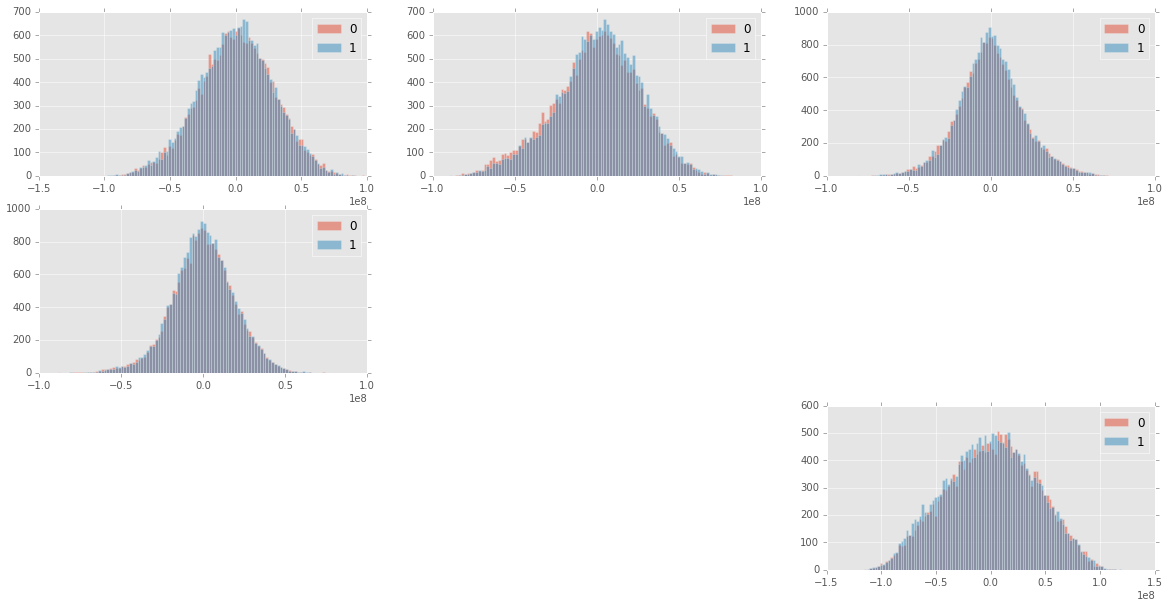

In [105]:
#LDA

#naive bayes gaussian

from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.lda import LDA
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
import math

variance_cutoff = 0.90

LDA_training_data = training_data.copy(deep = True)

#features:
features = list(set(LDA_training_data.columns).difference({'target', 'validation','c1'}))
print ("\n\n\nFeatures are: %s" %','.join(features))

#centering
LDA_training_data[features] = LDA_training_data[features].apply(lambda x: x-np.mean(x), axis=1)

#PCA
pca_ = PCA()
pca_.fit(LDA_training_data[features])
principal_components_features = map(lambda t: t[0]+str(t[1]), zip(["PC_"]*len(features), range(1,len(features)+1)))
for f in principal_components_features:
    LDA_training_data[f] = 0
LDA_training_data.loc[:,principal_components_features] = pca_.transform(LDA_training_data[features])

l_principal_components = np.argmax(np.cumsum(np.array(pca_.explained_variance_ratio_))>variance_cutoff)
principal_components_features = principal_components_features[0:l_principal_components]

#category
#try:
#    LDA_training_data["c1_int"] = LDA_training_data["c1"].apply(lambda x: int(x[3:]))
#except Exception:
#    le = preprocessing.LabelEncoder()
#    le.fit_transform(list(set(LDA_training_data["c1"])))
#    LDA_training_data["c1_int"] = le.transform(np.asarray(LDA_training_data["c1"]))


plt.figure(figsize=(20,10))
for i in range(0,l_principal_components):
    ax = plt.subplot(math.ceil(math.sqrt(l_principal_components)), math.ceil(math.sqrt(l_principal_components)), i)
    bins = np.linspace(np.min(LDA_training_data.loc[:,principal_components_features[i]]), np.max(LDA_training_data.loc[:,principal_components_features[i]]), 100)
    ax.hist(LDA_training_data.ix[LDA_training_data.loc[:,'target']==0,principal_components_features[i]].tolist(), bins, alpha=0.5, label='0')
    ax.hist(LDA_training_data.ix[LDA_training_data.loc[:,'target']==1,principal_components_features[i]].tolist(), bins, alpha=0.5, label='1')
    ax.legend(loc='upper right')

plt.show()

#clf = sklearn.lda.LDA()
#clf.fit(LDA_training_data[features], LDA_training_data['target'],store_covariance=True)
#IS_score = clf.score(LDA_training_data[features], LDA_training_data['target'])
#CV_score = np.mean(cross_val_score(clf, LDA_training_data[features], LDA_training_data['target'], cv=10))

#print "in sample score: %s, out of sample score: %s" %(IS_score,CV_score)

#LDA_training_data['lda_dir1'] = clf.transform(LDA_training_data[features])


#bins = np.linspace(-2, 2, 100)
#plt.hist(LDA_transformed_data.ix[LDA_transformed_data.loc[:,'target']==0,'lda_dir1'].tolist(), bins, alpha=0.5, label='0')
#plt.hist(LDA_transformed_data.ix[LDA_transformed_data.loc[:,'target']==1,'lda_dir1'].tolist(), bins, alpha=0.5, label='1')
#plt.legend(loc='upper right')
#plt.show()






Features are: f1,f2,f3,f4,f5,f6,f7,f8,f9,f12,f13,f10,f11,f14


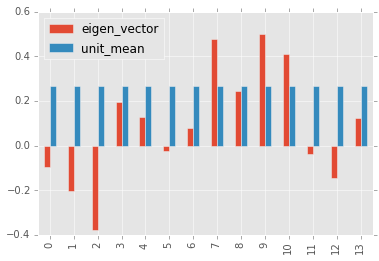

In [99]:
#LDA

#naive bayes gaussian

from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
import numpy as np
from sklearn.lda import LDA
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
variance_cutoff = 0.75

LDA_training_data = training_data.copy(deep = True)

#features:
features = list(set(LDA_training_data.columns).difference({'target', 'validation','c1'}))
print ("\n\n\nFeatures are: %s" %','.join(features))

#centering
LDA_training_data[features] = LDA_training_data[features].apply(lambda x: x-np.mean(x), axis=1)

#PCA
pca_ = PCA()
pca_.fit(LDA_training_data[features])
principal_components_features = map(lambda t: t[0]+str(t[1]), zip(["PC_"]*len(features), range(1,len(features)+1)))
for f in principal_components_features:
    LDA_training_data[f] = 0
LDA_training_data.loc[:,principal_components_features] = pca_.transform(LDA_training_data[features])

l_principal_components = np.argmax(np.cumsum(np.array(pca_.explained_variance_ratio_))>variance_cutoff)
principal_components_features = principal_components_features[0:l_principal_components]

first_eigenvector = pca_.components_[0]
a = LDA_training_data[features].apply(np.mean, axis=0)
b = LDA_training_data[features].apply(np.std, axis=0)
unit_mean = pd.concat([a, b], axis=1).loc[:,0]
unit_mean = unit_mean/np.sqrt(np.sum(unit_mean**2))

pd.DataFrame(zip(first_eigenvector,unit_mean.tolist()), columns=['eigen_vector','unit_mean']).plot(kind='bar')

In [92]:
LDA_training_data = pd.DataFrame(np.random.randn(100,14)+1000, columns=map(lambda t: t[0]+str(t[1]), zip(['f']*14, range(1,15))))
(w,v) = np.linalg.eigh(np.dot(np.transpose(LDA_training_data[features].as_matrix()),LDA_training_data[features].as_matrix()))
print v[:,13]

[ 0.26728344  0.26726831  0.26724864  0.26724856  0.26721227  0.26726284
  0.26726594  0.2672452   0.26724775  0.26725626  0.26732469  0.26724897
  0.26727204  0.26727246]


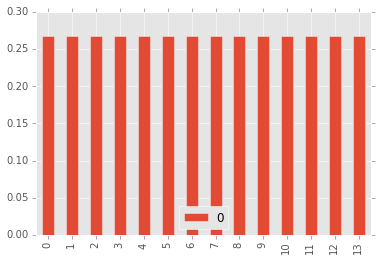

In [76]:
pd.DataFrame(v[:,13]).plot(kind='bar')

In [83]:
pca_.components_[13,:]

array([-0.1662101 , -0.12293247,  0.18176329,  0.30887437, -0.17413271,
        0.09058132, -0.11195485, -0.07218823,  0.70127759, -0.38076134,
        0.04907278,  0.00952519, -0.36481924, -0.01367218])